In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## importing stuff
import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import numpy as np
np.corrcoef(*np.random.randn(2,3))
import matplotlib.pyplot as plt
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from caiman import movie as cmovie
    from caiman import load as cload

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import PicklePicker as pp

from IPython.display import display
import pandas as pd
from islets.Recording import Recording, saveMovie
from islets.Regions1 import Regions
from islets.numeric import power_spectrum, rebin
from islets.utils import show_movie, saveRois
from matplotlib.colors import LogNorm

In [2]:
# from copy import deepcopy
fracSaturTh = .05
# movieFreq = 2
cmap = plt.cm.Greys
cmap.set_bad("lime")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys"))
  """


In [3]:
# plt.rcParams["animation.embed_limit"] = 600

In [4]:
# pp.PicklePicker("/data/Sandra/2020/2020_07_15/Experiment60b.lif","")

In [5]:
# regions = pp.regions

In [6]:
todo = pd.read_csv("/data/Sandra/presentation_2020_10.txt")

In [7]:
from islets.Recording import import_data

In [8]:
todo.columns = map(str.strip, todo.columns)

In [10]:
todo = todo[:-1] # because of movement

In [11]:
database = []
for j,row in todo.iterrows():
    exp = row.Experiment
    df = import_data("/data/Sandra/2020", exp)
    ser = row.Series.strip()
    df = df.query(f"series=='{ser}'")
    if len(df)==0:
        raise UserWarning(f"Did not find {ser} in {exp}")
    elif len(df)>1:
        raise UserWarning(f"Found more than one series corresponding to {ser} in {exp}")
    else:
        df = df.iloc[0]
        for col in ["sex","dye","slice number","part of pancreas","microscope","species"]:
            del df[col]
        database += [df]

In [12]:
database = pd.DataFrame(database)

In [13]:
database.index = range(len(database))

In [14]:
# database["Why"] = todo

In [15]:
todo

Experiment         Series                Why
0  Experiment63d   Series004-12       Xestospongin
1  Experiment58b    Series001-2       Xestospongin
2  Experiment67b   Series012-17   Ryanodine 100 nM
3  Experiment64e    Series002-3          ACh 10 uM

In [16]:
from islets.Regions1 import load_regions

In [17]:
for i,row in database.iterrows():
    print(row.experiment)
    protocolPath = row["path to protocol"]
    saveDir = os.path.split(protocolPath)[0]
    pickles = sorted([f for f in os.listdir(saveDir) if f.endswith("pkl")])
    print (pickles)
    database.loc[i,"regions"] = load_regions(os.path.join(saveDir, pickles[-1]))

Experiment63d.lif
['4.5_rois.pkl', '4.6_rois.pkl', '4_rois.pkl', '5_rois.pkl']


/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:713: RuntimeWarning: invalid value encountered in sqrt
  std = var**.5
/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:551: RuntimeWarning: invalid value encountered in log
  d = np.digitize(np.log(slow_est), logbs)


Experiment58b.lif
['3.4_rois.pkl', '3.5_rois.pkl', '3_rois.pkl', '4_rois.pkl']


/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:713: RuntimeWarning: invalid value encountered in sqrt
  std = var**.5


Experiment67b.lif
['5.6_rois.pkl', '5.7_rois.pkl', '5_rois.pkl', '6_rois.pkl']


/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:713: RuntimeWarning: invalid value encountered in sqrt
  std = var**.5
/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:551: RuntimeWarning: invalid value encountered in log
  d = np.digitize(np.log(slow_est), logbs)


Experiment64e.lif
['5.6_rois.pkl', '5.7_rois.pkl', '5_rois.pkl', '6_rois.pkl']


/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:713: RuntimeWarning: invalid value encountered in sqrt
  std = var**.5


In [164]:
# fix the movement in the Experiment63d Series004-12
regions = database.loc[0,"regions"]
igap0 = np.searchsorted(regions.time, 4485)
igap1 = np.searchsorted(regions.time, 4530)

traces = np.vstack(regions.df.trace)

s,f,z = regions.fast_filter_traces(200, z_sp=0, Npoints=np.inf, write=False)

for i in range(len(traces)):
    traces[i, igap0:igap1] = s[i,igap0:igap1]

regions.df["traces"] = list(traces)

/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:713: RuntimeWarning:

invalid value encountered in sqrt



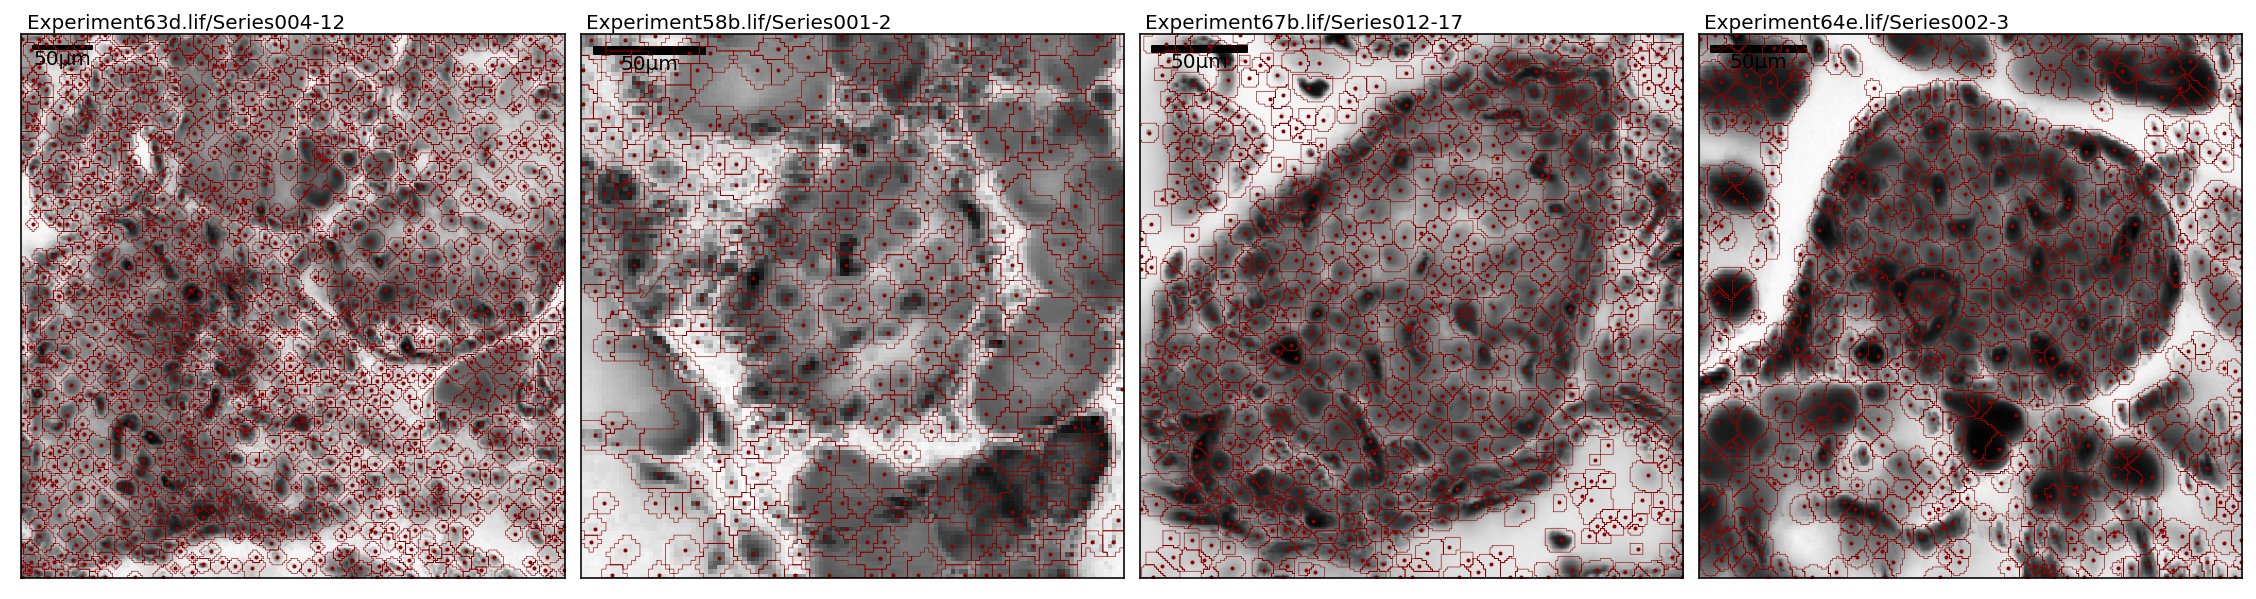

In [18]:
nc = 5
nr = int(np.ceil(len(database)/nc))
fig, axs = plt.subplots(nr,nc,figsize=(nc*5,nr*5), squeeze=False)
for (i,row) in database.iterrows():
    ax = axs.flat[i]
    ax.text(.01,1.01,f"{row.experiment}/{row.series}", transform = ax.transAxes,color="k")
    ax.set_xticks([])
    ax.set_yticks([])
    regions = database.loc[i,"regions"]
    regions.plotEdges(ax=ax, lw=.3,color="darkred")
    regions.plotPeaks(ax=ax, color="darkred")
#     break
for j in range(i+1,axs.size):
    axs.flat[j].remove()
plt.subplots_adjust(wspace=.01,hspace=0.01)

In [19]:
# for i in database.index:
#     regions = database.loc[i,"regions"]
#     print (database.loc[i,"experiment"])
#     if hasattr(regions,"protocol"):
#         print (regions.protocol)
#     else:
#         print ("#"*20)

In [169]:
freqs = []
powerSpectra = []
for i in database.index:
    regions = database.loc[i,"regions"]
    X = np.array([(tr-tr.mean())/tr.std() for tr in regions.df.trace])
    frqs, pws = power_spectrum(X, regions.Freq, mean=False)
    pws  = np.abs(pws)
    rpws = cmovie(pws.T.reshape(pws.shape[::-1]+(1,)),fr=1/frqs[1]).resize(1,1,frqs[1]/.01)[:,:,0].T
    frqs = cmovie(frqs.reshape(-1,1,1),fr=1/frqs[1]).resize(1,1,frqs[1]/.01).flatten()
    freqs+=[frqs]
    powerSpectra += [rpws]

In [170]:
# n = 10
# plt.plot(frqs, pws[0], lw=.3)
# plt.plot(rebin(frqs,n), rebin(pws[0],n), lw=1)
# plt.plot(freqs[-1], rpws[0])
# plt.yscale("symlog")
# plt.xscale("symlog")

In [236]:
from islets.numeric import mydebleach

In [ ]:
%%time my

In [171]:
[(frqs[0], len(frqs), np.diff(frqs).mean(), frqs.max()) for frqs in freqs]

[(0.004925070118454856, 990, movie(0.01000015), movie(9.895075)),
 (0.004944453372554417, 990, movie(0.01000006), movie(9.895)),
 (0.004860760696329605, 2250, movie(0.01000012), movie(22.49513928)),
 (0.0048431983592672955, 990, movie(0.01000032), movie(9.89515676))]

In [234]:
for i in database.index:
    traces = database.loc[i, "regions"].df["trace"]
    break

In [235]:
regions.detrend_traces?

In [ ]:
shapiro(tra)

In [172]:
# i = 1
# pwInFourier = (np.abs(pws[i])**2).sum()*
# pwInX = (X[i]**2).sum()/regions.Freq
# pwInX/pwInFourier

In [173]:
minLfreqs = min(map(len,freqs))

In [174]:
CommonFreqs = np.mean([fr[:minLfreqs] for fr in freqs],0)

In [175]:
minFreq = .05

In [176]:
# CommonFreqs>minFreq

In [223]:
pwsShow = np.vstack([pws[:,:minLfreqs][:,CommonFreqs>minFreq] for pws in powerSpectra])
# pwsShow = np.diff(pwsShow,axis=1)

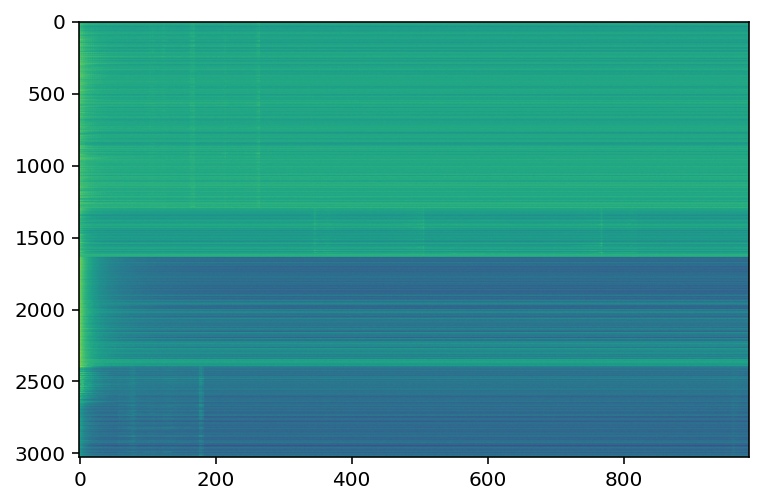

In [224]:
plt.imshow(pwsShow, aspect="auto", norm=LogNorm())

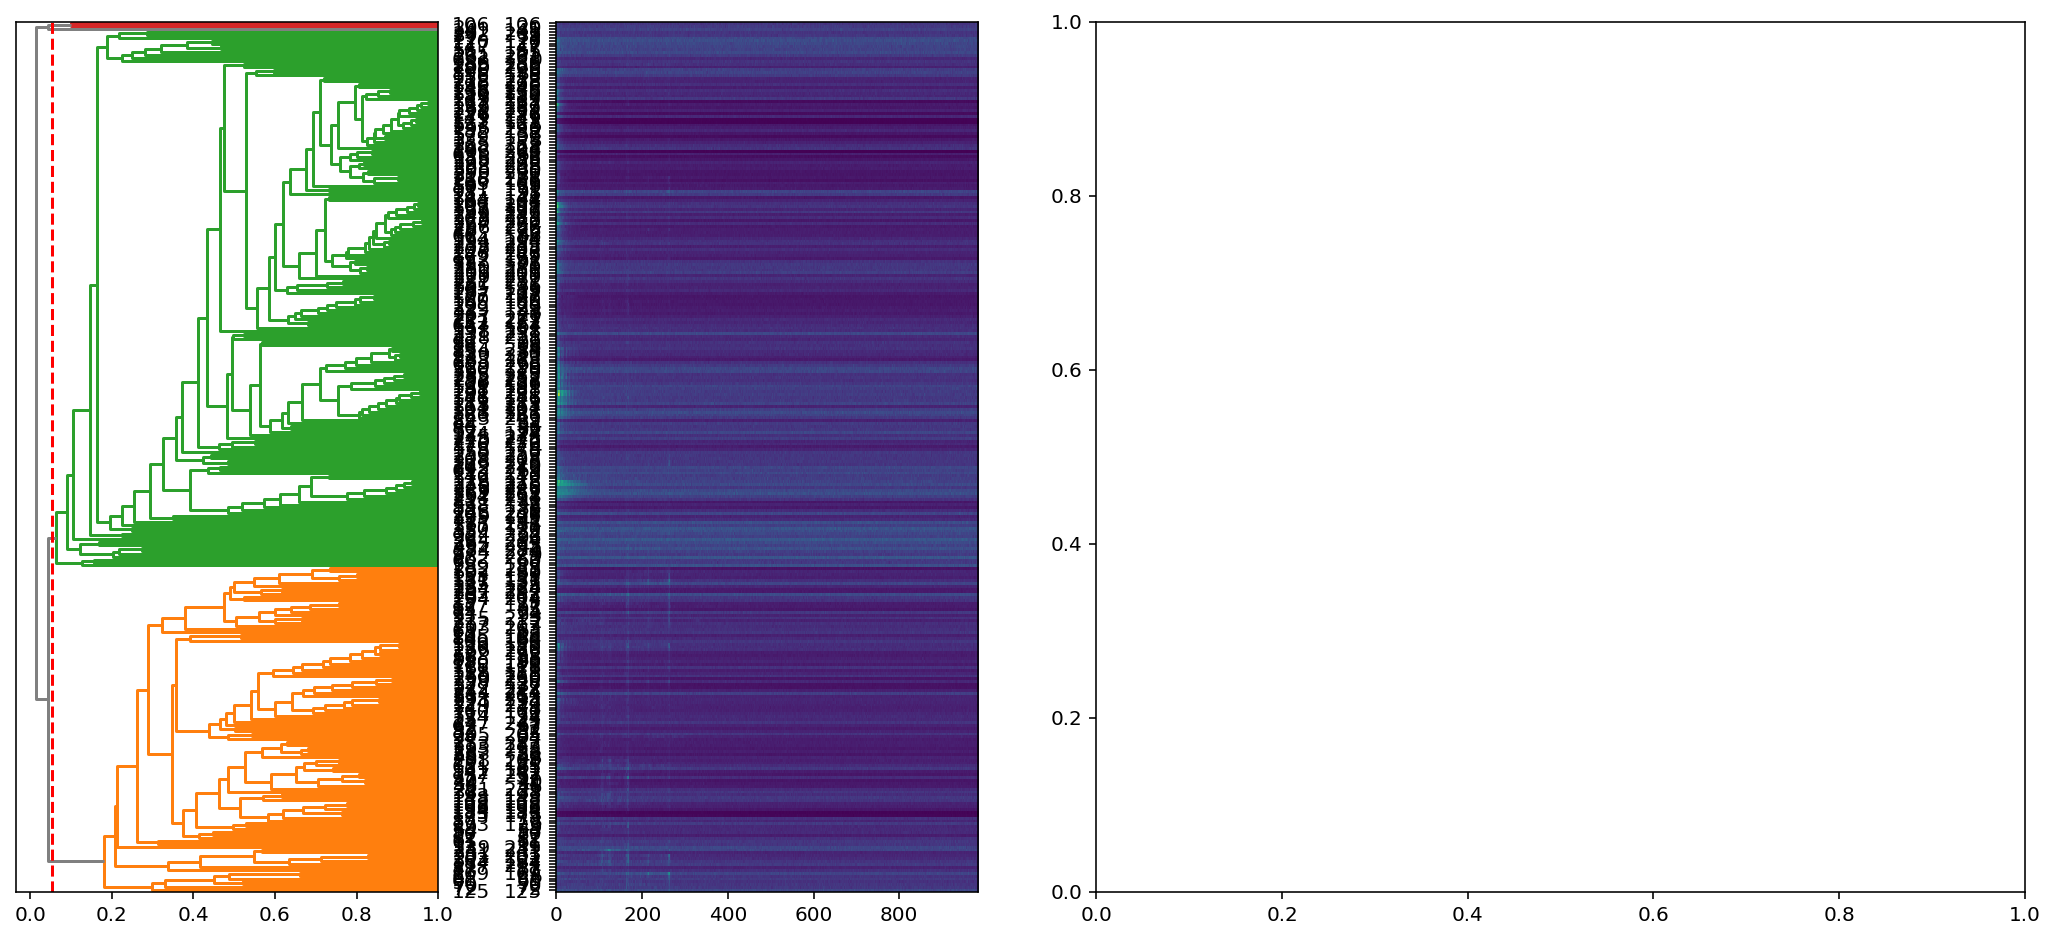

In [228]:
clusterCutAndPlot(pwsShow[:300],
                      function="agglomerative",
#                       functionArgs=("min","correlation"),
                      threshold=4,
#                       labels=[""]*,
                      );

In [ ]:
clusterCutAndPlot(Xdata,
                      mode=None,
                      function=linkage,
                      functionArgs=("complete","correlation"),
                      threshold=threshold,
                      criterion=criterion,
                      labels=labels,
                      imshow_kw = imshow_kw,
                      showClusterBoundaries=showClusterBoundaries,
                      )

In [202]:
from sklearn.cluster import KMeans

In [215]:
from islets.numeric import agglomerativeLinkage, clusterCutAndPlot, linkage

In [203]:
kmeans = KMeans(9)
kmeans.fit(pwsShow)

KMeans(n_clusters=9)

In [204]:
clIds = kmeans.predict(pwsShow)

In [205]:
clCounts = pd.Series(clIds).value_counts().sort_values(ascending=False)

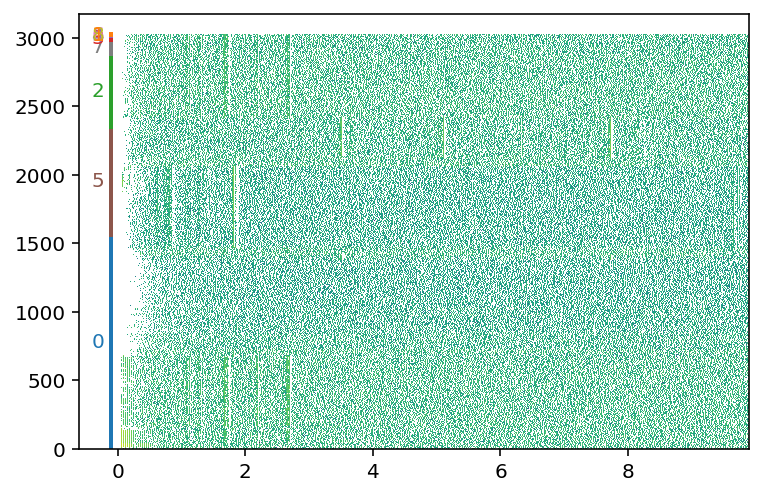

In [207]:
x = np.vstack([pwsShow[clIds==i] for i in clCounts.index])
# x[:,CommonFreqs<.1] = np.nan
cm = CommonFreqs[CommonFreqs>minFreq]
plt.imshow(x, aspect="auto",
           norm=LogNorm(),
           extent=(cm[0],cm[-1],-.5, len(pwsShow)-.5)
          )
for ic in clCounts.index:
        y = [clCounts.loc[:ic].sum(), clCounts.loc[:ic][:-1].sum()]
        x = -.1
        c = colors[ic%len(colors)]
        plt.plot([x,x],y,c=c,lw=2)
        plt.text(x,np.mean(y),str(ic)+" ",va="center",ha="right",color=c)

In [185]:
showFreq = 1

In [186]:
def hex2rgb(h):
    return tuple(int(h.lstrip("#")[i:i+2], 16)/255 for i in [0,2,4])

In [187]:
# plt.plot(np.random.rand(4), color=(.7,.3,.1))

In [188]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]

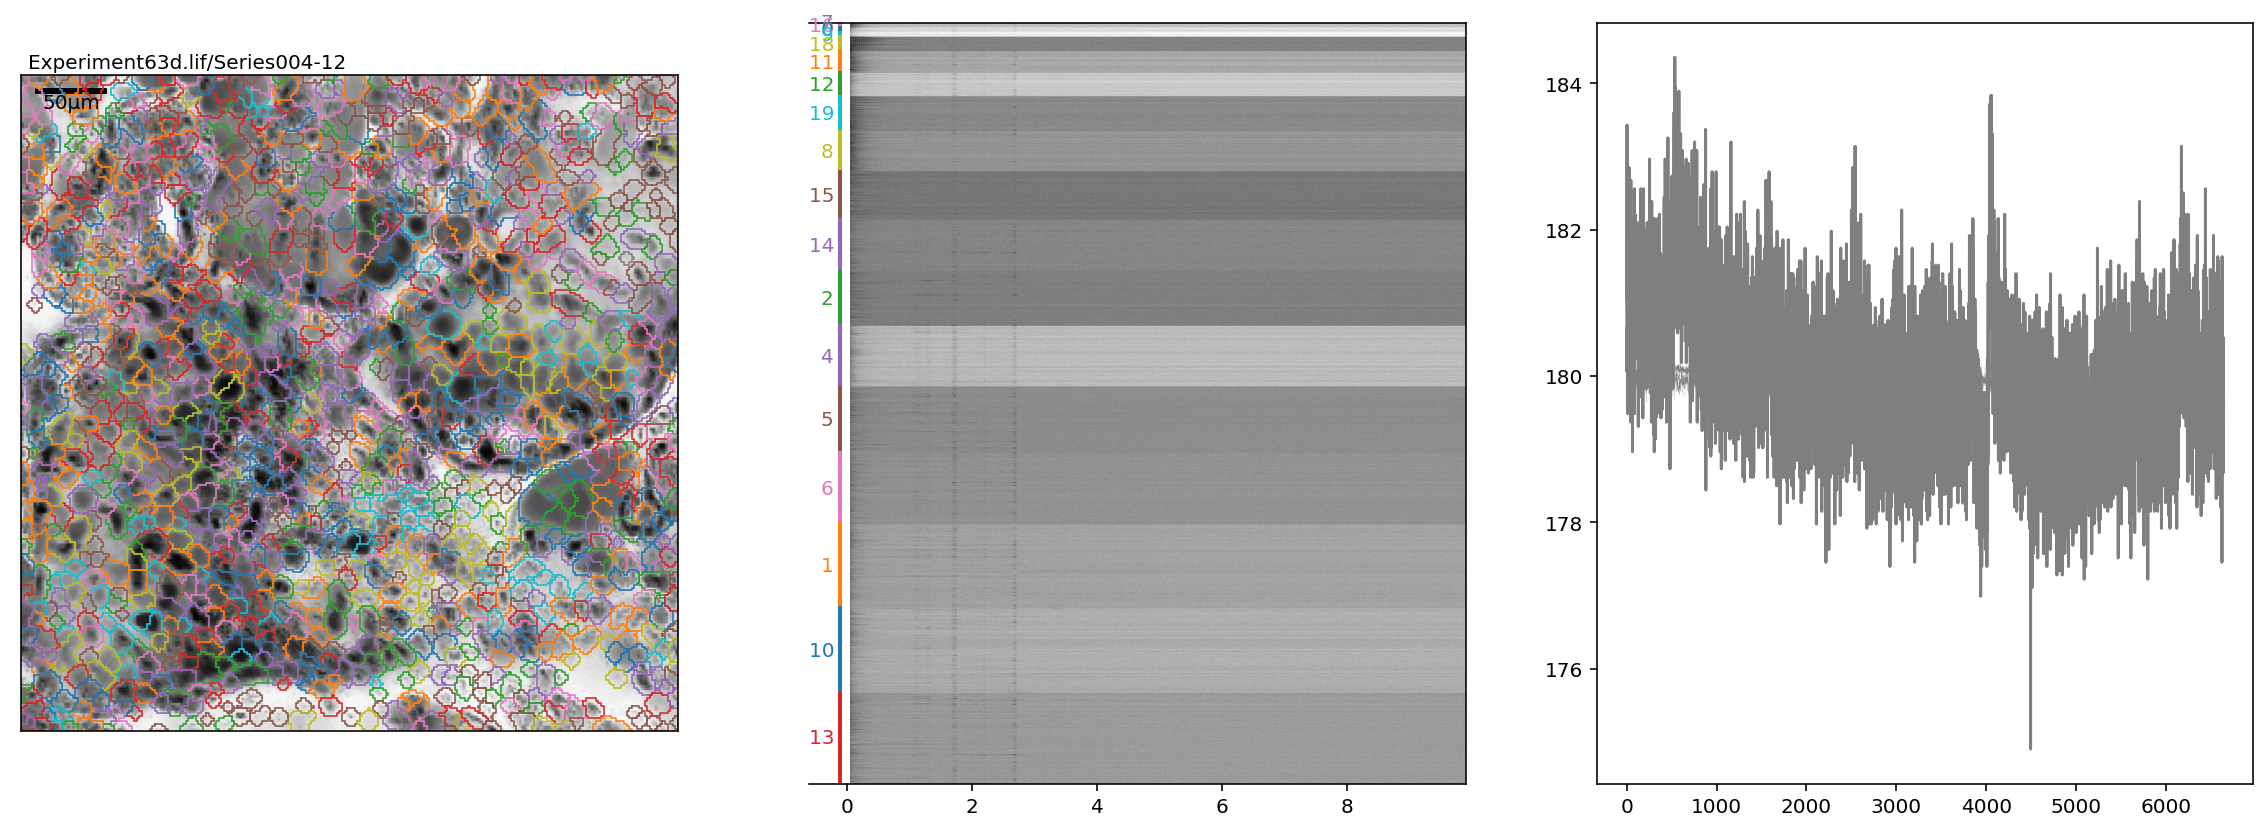

In [189]:
# nc = 3
# nr = len(database)
# axs = axs.reshape((nr,2,nc)).transpose((0,2,1))
for (i,row) in database.iterrows():
#     if i<4: continue
    fig, axs = plt.subplots(1,nc,figsize=(20,7), squeeze=True)
    ax, ap, al= axs
    ax.text(.01,1.01,f"{row.experiment}/{row.series}", transform = ax.transAxes,color="k")
    ax.set_xticks([])
    ax.set_yticks([])
    ap.set_yticks([])
    regions = database.loc[i,"regions"]
    pw = powerSpectra[i][:,:minLfreqs][:,CommonFreqs>minFreq]
    regions.df["clusterID"] = kmeans.predict(pw)
    regions.df["color"] = [colors[j%len(colors)] for j in regions.df["clusterID"]]
    regions.plotEdges(separate=True,ax=ax)
#     x = powerSpectra[i][:,:minLfreqs]
#     x[:,CommonFreqs<=minFreq] = np.nan
#     x = x[np.argsort(regions.df.color)]
    clCounts = regions.df.clusterID.value_counts().sort_values()
    x = np.vstack([pw[regions.df.clusterID==cl] for cl in clCounts.index])
    ap.imshow(x, norm=LogNorm(), aspect="auto", extent=(minFreq, CommonFreqs[-1],len(x),0), cmap="Greys")
    ap.spines["left"].set_visible(False)
    for ic in clCounts.index:
        y = [clCounts.loc[:ic].sum(), clCounts.loc[:ic][:-1].sum()]
        x = -.1
        c = colors[ic%len(colors)]
        ap.plot([x,x],y,c=c,lw=2)
        ap.text(x,np.mean(y),str(ic)+" ",va="center",ha="right",color=c)
    dists = kmeans.transform(pw)
    representatives = {}
    ia = len(clCounts)
    for ic in clCounts.index: 
        c = colors[ic%len(colors)]
        ix = np.argmin(dists[:,ic])
        x = regions.df.detrended.iloc[ix]
        xs = np.vstack(regions.df.query(f"clusterID=={ic}").detrended)
        t = regions.time
        n = int(np.round(regions.Freq/showFreq))
        if n>1:
            x = rebin(x,n)
            t = rebin(t,n)
            xs = rebin(xs,n,1)
        representatives[ic] = x
        x = (x-x.mean())/x.std()
        al.plot(t,x+10*ia,c=c)
        al.plot(t,xs.T+10*ia,c=c,lw=.1)
        break
#         ia -= 1
#         if ia>3: break
    break
# for j in range(i+1,len(database)):
#     for ax in axs[j]: ax.remove()
# plt.subplots_adjust(wspace=.1,hspace=0.1)

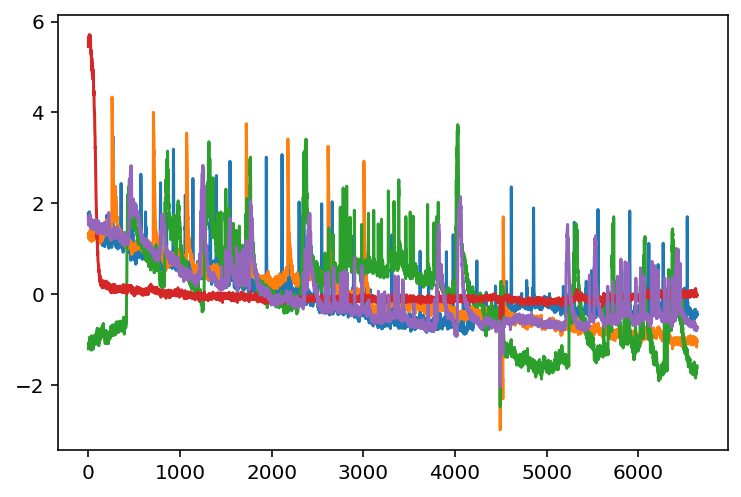

In [96]:
plt.plot(t,xs.T)

In [120]:
for ts in [3,10,30,100]:
    if not hasattr(regions,"peaks") or  "%g"%ts not in regions.peaks:
        regions.calc_peaks(ts)
    regions.df["n_peaks_%g"%ts] = 0
    for roi,df in regions.peaks["%g"%ts].groupby("roi"):
        regions.df.loc[roi,"n_peaks_%g"%ts] = len(df)

In [127]:
# from CrossfilterApp import crossfilterApp

In [128]:
# pd.plotting.scatter_matrix(np.log10(1+regions.df[[c for c in regions.df.columns if "n_peaks" in c]]))

In [130]:
# crossfilterApp(np.log10(1+regions.df[[c for c in regions.df.columns if "n_peaks" in c]]), ms=2)

In [102]:
regions.time.shape, regions.df.zScore_30[0].shape

((131506,), (3287,))

In [124]:
regions.examine3(startShow="[236]")

/home/jupyter-srdjan/srdjan_functs/islets/utils.py:329: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [158]:
for c in regions.df.columns:
    if "slow" in c or "fast" in c or "zScore" in c:
        del regions.df[c]
if hasattr(regions, "showTime"):
    del regions.showTime

In [159]:
# regions.fast_filter_traces(200, z_sp=0, Npoints=np.inf)

In [163]:
todo

Experiment         Series                Why
0  Experiment63d   Series004-12       Xestospongin
1  Experiment58b    Series001-2       Xestospongin
2  Experiment67b   Series012-17   Ryanodine 100 nM
3  Experiment64e    Series002-3          ACh 10 uM

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N 

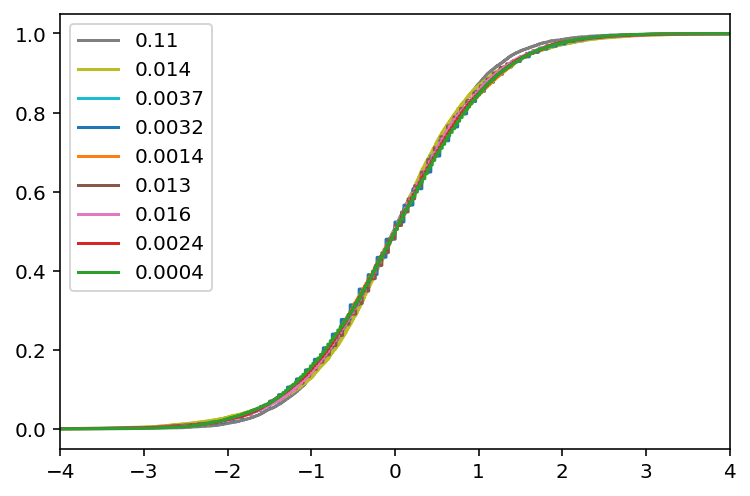

In [82]:
for ic in representatives:
    c = colors[ic%len(colors)]
    x = np.diff(representatives[ic])
#     plt.hist(x, histtype="step",color=c)
    x = (x-x.mean())/x.std()
    x.sort()
    plt.plot(x, np.linspace(0,1,len(x)),c=c,label="%.2g"%(1-shapiro(x).statistic))
plt.xlim(-4*x.std(), 4*x.std())
plt.legend()

In [71]:
from scipy.stats import shapiro

In [72]:
shapiro(x)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9995923042297363, pvalue=0.005523489788174629)

In [412]:
# regions.examine3(max_rois=30)

In [403]:
from scipy.stats import distributions as dst

In [410]:
dst.norm.sf(10)*2

1.523970604832094e-23

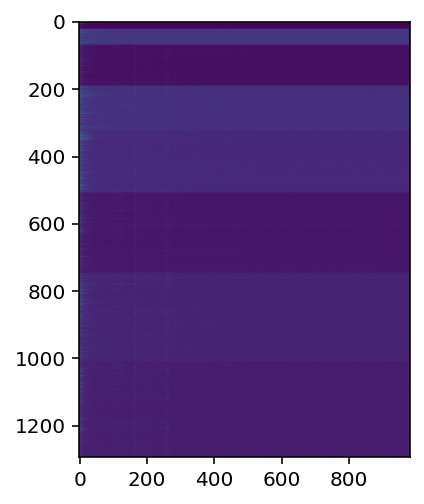

In [345]:
plt.imshow(x)

In [241]:
# clCounts = regions.df.clusterID.value_counts()

<BarContainer object of 10 artists>

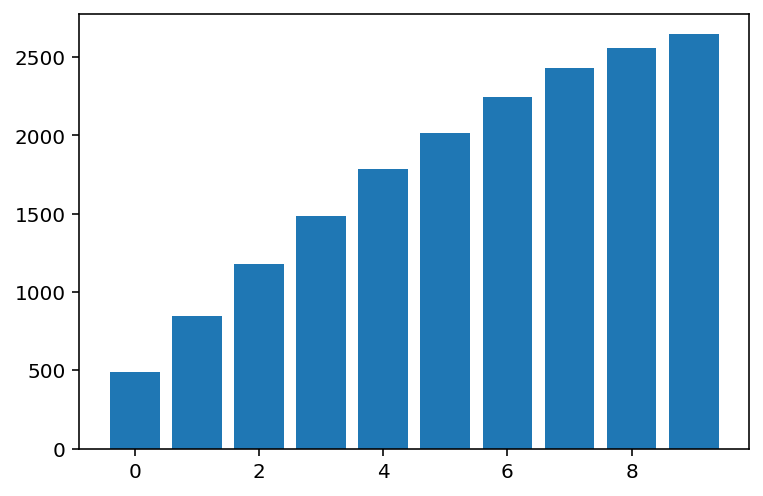

In [256]:
plt.bar(np.arange(len(clCounts)), clCounts.values.cumsum())
# plt.xticks(np.arange(len(clCounts)), clCounts.index);

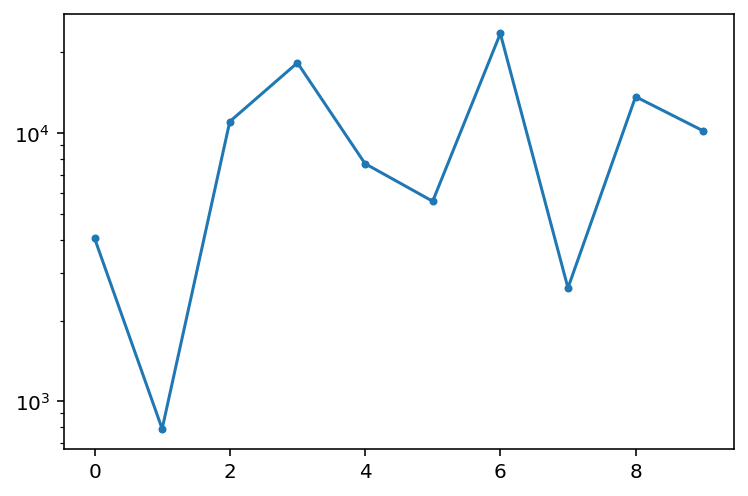

In [192]:
plt.plot([pws[clIds==i].std() for i in np.unique(clIds)],".-")
plt.yscale("log")

In [105]:
clIds = kmeans.predict(pws)
clSort = np.argsort([pws[clIds==i].std() for i in np.unique(clIds)])[::-1]

In [111]:
x = np.vstack([pws[clIds==i] for i in clSort])

Text(0.5, 0, 'Frequency [Hz]')

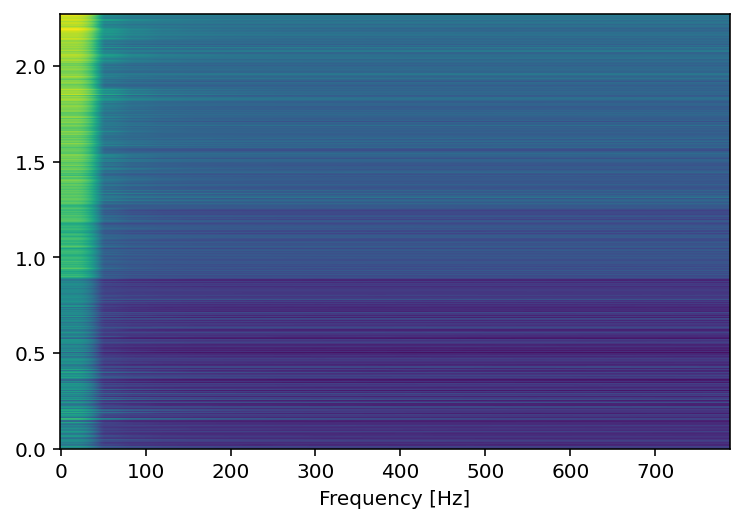

In [116]:
plt.imshow(np.vstack([pwsShow[clIds==i] for i in clSort]), aspect="auto", extent=(-.5,len(regions.df)-.5,0,frqs[-1]), norm=LogNorm())
plt.xlabel("Frequency [Hz]")

In [117]:
regions.df["clusterID"] = clIds

In [118]:
np.unique(clIds)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [130]:
int("200",16)

512

In [131]:
def hex2rgb(h):
    return tuple(int(h.lstrip("#")[i:i+2], 16)/255 for i in [0,2,4])

In [135]:
# plt.plot(np.random.rand(4), color=(.7,.3,.1))

In [153]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]

In [147]:
colors = list(map( hex2rgb, a.by_key()["color"]))

In [155]:
regions.df["color"] = [colors[j%len(colors)] for j in clIds]

In [124]:
# import_data("/data/Sandra/2019/2019_09_03/", verbose=2)

In [112]:
rec = Recording("/data/Sandra/2019/2019_08_12/Experiment28.lif")

In [113]:
rec.calc_gaps()

In [114]:
rec.metadata

Name  SizeT  SizeX  SizeY  SizeZ  pxSize pxUnit bit depth  Frequency  \
0    Image005      1   1024   1024      1   0.390     µm     uint8        NaN   
1    Image008      1   1024   1024      1   0.316     µm     uint8        NaN   
2    Image011      1   1024   1024      1   0.316     µm     uint8        NaN   
3    Image013      1   1024   1024      1   0.316     µm     uint8        NaN   
4   Series015   6659    512    512      1   0.632     µm     uint8       1.98   
5    Image019      1   1024   1024      1   0.287     µm     uint8        NaN   
6    Image021      1   1024   1024      1   0.287     µm     uint8        NaN   
7   Series022   5111    512    512      1   0.575     µm     uint8       1.98   
8    Image026      1   1024   1024      1   0.259     µm     uint8        NaN   
9    Image033      1   1024   1024      1   0.260     µm     uint8        NaN   
10  Series034   1341    512    512      1   0.521     µm     uint8       1.98   
11   Image040      1   1024   1024      1   0.298     µm     uint8        NaN   
12  Series041   8000    512    512      1   0.596     µm     uint8       1.98   
13  Series042   1814    512    512      1   0.596     µm     uint8       1.98   
14   Image044      1   1024   1024      1   0.360     µm     uint8        NaN   
15   Image047      1   1024   1024      1   0.236     µm     uint8        NaN   
16   Image049      1   1024   1024      1   0.236     µm     uint8        NaN   
17   Image051      1   1024   1024      1   0.236     µm     uint8        NaN   
18  Series052     40   1024   8192      1   0.236     µm     uint8       1.98   
19  Series053     22   1024   8192      1   0.236     µm     uint8       2.12   
20  Series054     40    512   8192      1   0.473     µm     uint8       1.97   
21  Series055     40    512   8192      1   0.473     µm     uint8       1.97   
22  Series056  13113    512      2      1   0.473     µm     uint8     330.00   
23  Series057    487     64     64      1   3.840     µm     uint8      22.30   
24  Series059   4897     64     64      1   1.270     µm     uint8     110.00   
25   Image061      1   1024   1024      1   0.259     µm     uint8        NaN   
26  Series062   6386    512    512      1   0.519     µm     uint8       1.98   
27   Image069      1   1024   1024      1   0.328     µm     uint8        NaN   
28  Series070      1   1024   1024      1   0.328     µm     uint8        NaN   
29  Series071   2378    512    512      1   0.657     µm     uint8       1.98   
30   Image078      1   1024   1024      1   0.260     µm     uint8        NaN   
31  Series079   5184    512    512      1   0.520     µm     uint8       1.98   
32   Image082      1   1024   1024      1   0.325     µm     uint8        NaN   
33   Image084      1   1024   1024      1   0.325     µm     uint8        NaN   
34  Series085   4617    512    512      1   0.650     µm     uint8       1.98   

            Start time            End time                  Duration  \
0  2019-08-12 11:01:35                 NaT                       NaT   
1  2019-08-12 11:08:00                 NaT                       NaT   
2  2019-08-12 11:10:15                 NaT                       NaT   
3  2019-08-12 11:10:52                 NaT                       NaT   
4  2019-08-12 11:11:45 2019-08-12 12:07:44 0 days 00:55:59.954000473   
5  2019-08-12 12:14:45                 NaT                       NaT   
6  2019-08-12 12:15:32                 NaT                       NaT   
7  2019-08-12 12:16:25 2019-08-12 12:59:23 0 days 00:42:58.806999207   
8  2019-08-12 13:06:28                 NaT                       NaT   
9  2019-08-12 13:12:45                 NaT                       NaT   
10 2019-08-12 13:13:33 2019-08-12 13:24:48 0 days 00:11:15.880998611   
11 2019-08-12 13:32:16                 NaT                       NaT   
12 2019-08-12 13:33:10 2019-08-12 14:40:27 0 days 01:07:17.836999893   
13 2019-08-12 14:40:28 2019-08-12 14:55:42 0 days 00:15:14.664999008   
14 2019-08-1

In [115]:
from islets.Recording import parse_leica

In [116]:
parse_leica(rec)

['Series015',
 'Series022',
 'Series034',
 'Series041-42',
 'Series052',
 'Series053',
 'Series054',
 'Series055',
 'Series056',
 'Series057',
 'Series059',
 'Series062',
 'Series070',
 'Series071',
 'Series079',
 'Series085']

In [226]:
import plotly_express as plx

In [234]:
regions.reassign_peaks(regions.statImages["mean"])

In [235]:
plx.scatter(regions.df,x="size",y="peakValue",log_y=True, color=regions.df.color, color_discrete_map="identity")

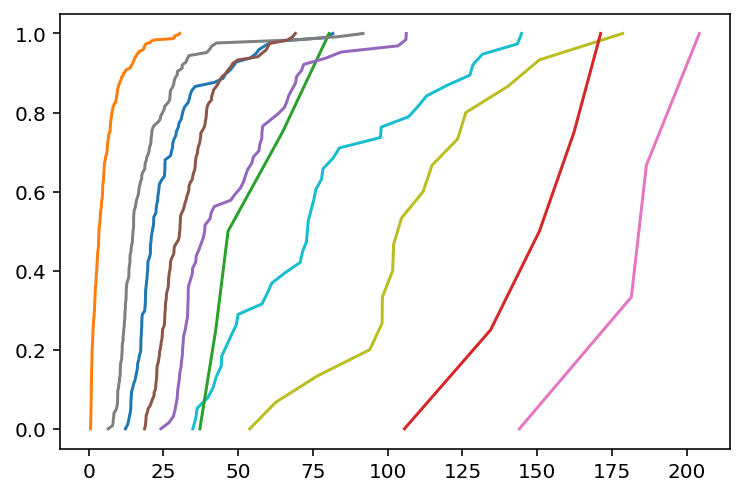

In [277]:
for c,df in regions.df.groupby("color"):
    x = df.peakValue.values
    x.sort()
    plt.plot(x, np.linspace(0,1,len(x)),c=c)

In [285]:
regions.df.peakValue.max()/20

10.20983193459076

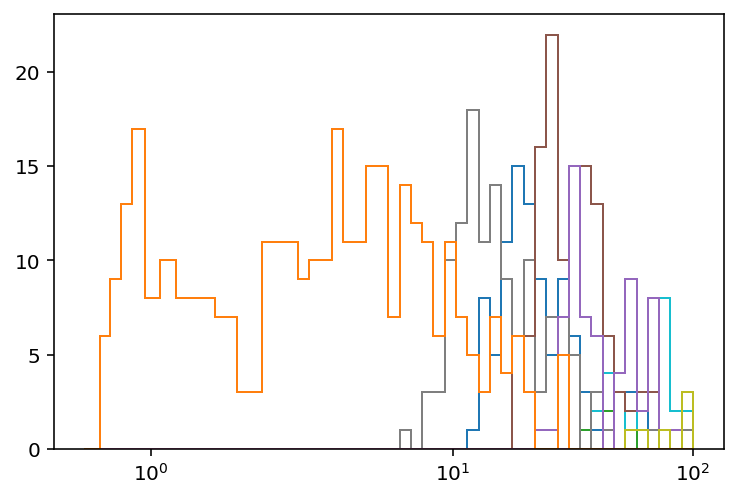

In [283]:
for c,df in regions.df.groupby("color"):
    x = df.peakValue.values
    plt.hist(x,np.logspace(-.3,2),color=c, histtype="step")
plt.xscale("symlog")

In [236]:
from islets.numeric import get_sep_th

In [244]:
from islets.numeric import robust_max

In [ ]:
from cv2 import 

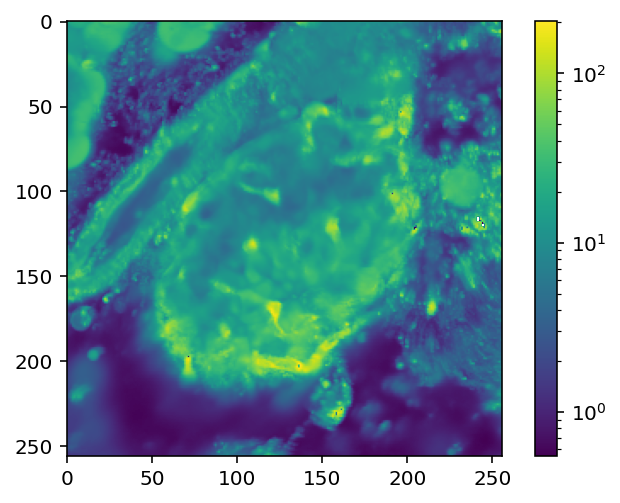

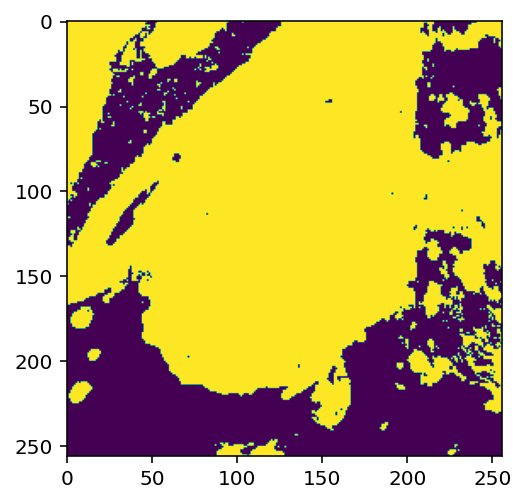

In [246]:
im = regions.statImages["mean"].copy()
plt.imshow(im, norm=LogNorm())
plt.colorbar()
plt.show()
im = im>robust_max(im)/50

plt.imshow(im)

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:159: RuntimeWarning:

divide by zero encountered in log10



11.59865479916825

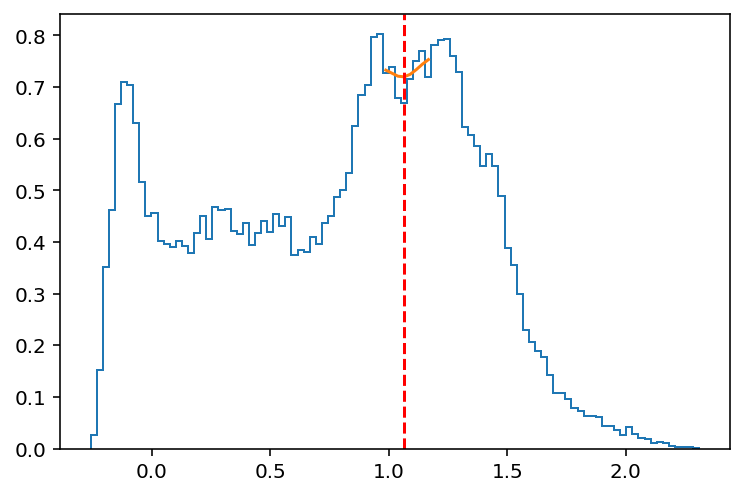

In [238]:
get_sep_th(regions.statImages["mean"].flat,log=True,plot=True)

In [ ]:
ts = 10
regions.calc_peaks(ts)
spikes = regions.peaks["%g"%ts]

In [ ]:
from scipy.stats import median_abs_deviation

In [ ]:
regions = pp.regions
type(regions)

In [ ]:
# regions.df.drop(index=regions.df.query("peakValue<0.02").index, inplace=True)

In [ ]:
# regions.examine3(
# #     startShow=regions.df.query("peakValue<0.05").index
# )

In [ ]:
ts = 10
regions.fast_filter_traces(ts,Npoints=np.inf)
regions.calc_raster(ts,z_th=5)

In [ ]:
plt.imshow(rebin(regions.raster["%g"%ts],20,axis=1), norm=LogNorm())
plt.gca().set_aspect("auto")

In [ ]:
regions.df = regions.df.iloc[:200]

In [ ]:
regions.update()

In [ ]:
regions.plotEdges()

In [ ]:
timeWindows=np.array(list(zip(tchanges[:-1],tchanges[1:])))

In [ ]:
timeWindows[:,0] += 5*60

In [ ]:
timeWindows

In [ ]:
labels = ["pH=7.4","pH=7.1"]

In [ ]:
for lbl, tw in zip(labels, timeWindows):
    spikes.loc[spikes.t0.between(*tw),"label"] = lbl

In [ ]:
summary = []#pd.DataFrame(columns=["roi", "pH","mean","std",])

for (roi,lbl),df in spikes.groupby(["roi","label"]):
    if len(df)<10: continue
    summary += [{
        "roi":roi,
        "label":lbl,
        "hw_median":  np.median(df.iloc[:,1]),
        "hw_mad":   median_abs_deviation(df.iloc[:,1]),
        "med_t_btw_spike_onset": np.median(df.t0.diff()[1:]),
        "mad_t_btw_spike_onset": median_abs_deviation(df.t0.diff()[1:]),
    }]

In [ ]:
summary = pd.DataFrame(summary)

In [ ]:
import plotly_express as plx

In [ ]:
fig = plx.scatter(summary.query("med_t_btw_spike_onset<40"),x="hw_median",y="med_t_btw_spike_onset",color="label",width=550,height=500,marginal_x="histogram",marginal_y="histogram")
fig

In [ ]:
for roi,df in summary.groupby("roi"):
    df = df.sort_values("label")
    plt.plot(df.hw_median,df.med_t_btw_spike_onset,"-",c="grey",lw=.4,alpha =.4)
for lbl in labels:
    df = summary.query(f"label=='{lbl}'")
    plt.plot(df.hw_median,df.med_t_btw_spike_onset,"o",label=lbl,mfc="none")
#     plt.errorbar(df.hw_median,df.med_t_btw_spike_onset,marker=".",label=lbl,ls="none",xerr=df.hw_mad, yerr=df.mad_t_btw_spike_onset,lw=.4)
plt.legend(loc=4)
plt.ylim(6,29)
plt.xlabel("median spike half-width")
plt.ylabel("median interval between spike onsets")

# Mess with the movie

In [200]:
import javabridge
from bioformats import JARS as bfJARS
javabridge.start_vm(class_path=bfJARS, max_heap_size="20G")

In [195]:
recFile = "/data/Sandra/2020/2020_07_15/Experiment60b.lif"

In [196]:
rec = Recording(recFile)

In [ ]:
# rec.parse_metadata()

In [ ]:
# im = rec.xml.image(3)
# T = im.Pixels.get_SizeT()

# t  = np.arange(0,T,100)
# tt = np.array([im.Pixels.Plane(j).DeltaT for j in t])
# # .Image()

# x = tt/t
# xm = np.nanmedian(x)
# print (xm)
# plt.plot(x-xm)
# # plt.yscale("log")

In [198]:
# series = "Series007-10"
series = "all"

In [201]:
rec.import_series(series)

In [202]:
freq = rec.Series[series]["metadata"]["Frequency"]

In [203]:
orig_movie = cmovie(rec.Series[series]["data"],fr=freq)

In [204]:
from islets.Regions1 import getStatImages

In [220]:
# statImages = getStatImages(orig_movie[:,-50:,-50:])

In [261]:
show_movie(orig_movie[:,120:150,:].resize(1,1,.02))

2730

In [264]:
orig_movie.fr

4.55

In [221]:
regions.filterSize

(6, 7)

In [273]:
t0 = int(600*orig_movie.fr)
rr = Regions(
    orig_movie[t0:,120:150,:], gSig_filt=(6,7), 
    mode="mean"
#     mode="mean+mean"
            )

In [276]:
__name__

'__main__'

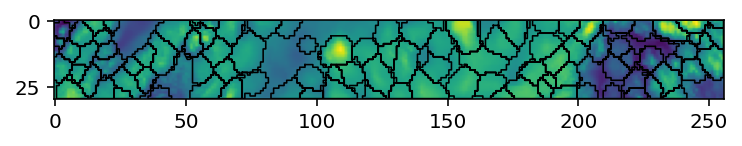

In [274]:
rr.plotEdges()

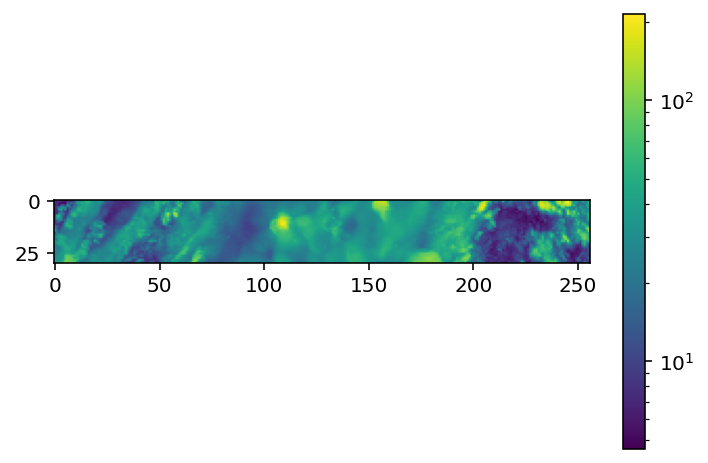

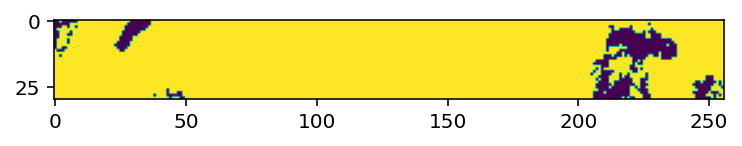

In [272]:
im = rr.statImages[rr.mode].copy()
plt.imshow(im, norm=LogNorm())
plt.colorbar()
plt.show()
im = im>robust_max(im)/20
plt.imshow(im)

In [267]:
rr.statImages[rr.mode]/rr.statImages["mean"]

movie([[3.53876749, 3.27269464, 6.36853132, ..., 1.73793596, 1.86827531,
        2.30557251],
       [3.51258049, 4.65639959, 4.42976044, ..., 2.00528087, 2.58587003,
        2.50460523],
       [3.51571397, 5.56484957, 3.52832709, ..., 2.01381159, 2.59960921,
        2.5792531 ],
       ...,
       [1.55971105, 1.52847876, 1.53073772, ..., 2.77410427, 3.6200075 ,
        4.68850051],
       [1.56162886, 1.54994244, 1.61387   , ..., 2.99290719, 3.08264683,
        3.95590895],
       [1.90979527, 1.7402151 , 1.61496761, ..., 4.95622599, 3.5173002 ,
        3.46932791]])

-inf

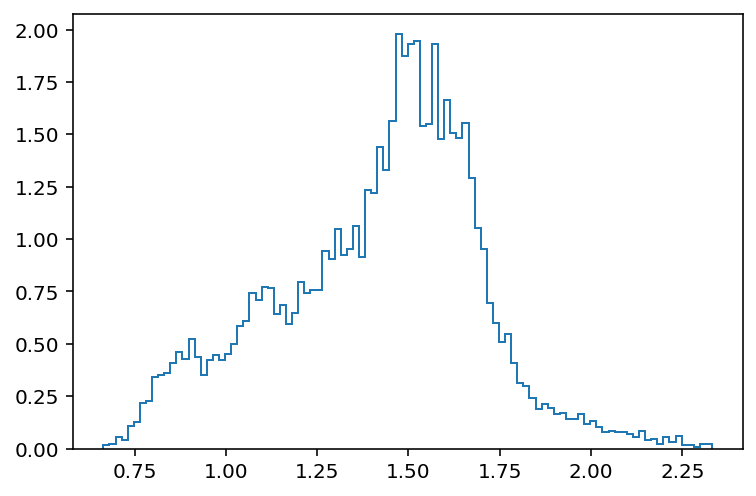

In [270]:
get_sep_th(rr.statImages[rr.mode].flat, log=True, plot=True)

In [275]:
rr.examine3()

/home/jupyter-srdjan/srdjan_functs/islets/utils.py:329: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [ ]:
# saveMovie(movie.resize(.02), "embed")

In [ ]:
rigshift_movie = cload(f"{recFile}_analysis/{series}/{rec.Experiment[:-4]}_{series}_rigidshifted.tif", fr=freq)

In [ ]:
from caiman import concatenate

In [ ]:
end = len(rigshift_movie)
n = 100
m = orig_movie[:end].resize(.5,.5,1/n)

In [ ]:
mshow = concatenate([
    m,
    np.ones_like(m[:,:,:1])*m.max(),
    rigshift_movie.resize(.5,.5,1/n)
],axis=2)

In [ ]:
mshow.shape, mshow.dtype

In [ ]:
# saveMovie(mshow, "embed", dpi=200)

In [ ]:
os.listdir(f"{recFile}_analysis/{series}/")

In [ ]:
regions = "/data/Sandra/2020/20"

In [ ]:
# pp.PicklePicker(recFile,ser)

In [ ]:
del regions.df["slower_10"], regions.df["faster_10"], regions.df["zScore_10"]

In [ ]:
tchanges = np.unique([regions.protocol.t_begin,regions.protocol.t_end])
# tchanges = tchanges[tchanges>0]

In [ ]:
ts = 5
regions.calc_peaks(ts)

In [ ]:
regions.show_scatter_peaks(ts, timeWindows=list(zip(tchanges[:-1],tchanges[1:])))

In [ ]:
del regions.peaks